In [321]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, accuracy_score, auc, roc_curve
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pd.set_option("display.max_columns", None)
pd.options.display.max_rows = 4000


In [17]:
import pymc3 as pm
from pymc3 import glm
import bambi

In [18]:
def plot_traces(traces, model, retain=0):
    """
    Convenience function:
    Plot traces with overlaid means and values
    """
    summary = az.summary(traces, stat_funcs={"mean": np.mean}, extend=False)
    ax = az.plot_trace(
        traces,
        lines=tuple([(k, {}, v["mean"]) for k, v in summary.iterrows()]),
    )

    for i, mn in enumerate(summary["mean"].values):
        ax[i, 0].annotate(
            f"{mn:.2f}",
            xy=(mn, 0),
            xycoords="data",
            xytext=(5, 10),
            textcoords="offset points",
            rotation=90,
            va="bottom",
            fontsize="large",
            color="C0",
        )

In [19]:
# Data Source: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers
# *NOTE: To fetch data, please run ~/get_data.sh script
df = pd.read_csv("data/BankChurners.csv")

# Data

## Data Exploration

In [20]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [21]:
# Drop variables that are not required
df.drop(
    [
        "CLIENTNUM",
        "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
        "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2",
    ],
    axis=1,
    inplace=True,
)


In [22]:
# Non-null data, balanced data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [23]:
df.describe(include="all")

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127,10127.000000,10127,10127.000000,10127,10127,10127,10127,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
unique,2,NaN,2,NaN,7,4,6,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Existing Customer,NaN,F,NaN,Graduate,Married,Less than $40K,Blue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8500,NaN,5358,NaN,3128,4687,3561,9436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,46.325960,NaN,2.346203,NaN,NaN,NaN,NaN,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,NaN,8.016814,NaN,1.298908,NaN,NaN,NaN,NaN,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,NaN,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,NaN,41.000000,NaN,1.000000,NaN,NaN,NaN,NaN,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,NaN,46.000000,NaN,2.000000,NaN,NaN,NaN,NaN,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,NaN,52.000000,NaN,3.000000,NaN,NaN,NaN,NaN,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000


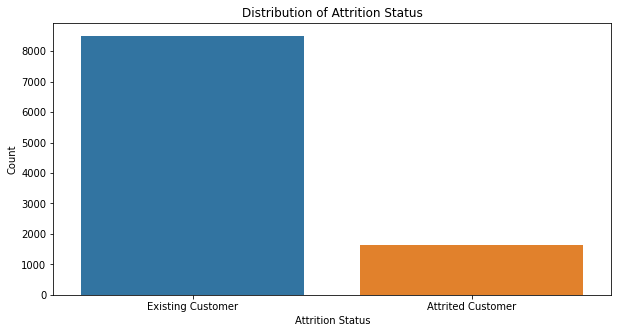

In [24]:
# Target Variable
m = df["Attrition_Flag"].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ["Attrition Status", "Count"]
plt.subplots(figsize=(10, 5))
sns.barplot(y="Count", x="Attrition Status", data=m)
plt.xlabel("Attrition Status")
plt.ylabel("Count")
plt.title("Distribution of Attrition Status")
plt.show()


## Data Pre-processing

### Convert target variable to binary variable

In [25]:
# Convert Categorical Variables to Numerical (1 == Bad credit)
def attrition_status(status):
    if status == "Existing Customer":
        return 0
    else:
        return 1
df["Attrition_Flag"] = df["Attrition_Flag"].apply(attrition_status)
df["Attrition_Flag"].value_counts()

0    8500
1    1627
Name: Attrition_Flag, dtype: int64

### Encoding of categorical variables (OneHotEncoding / LabelEncoding)

As there are categorical values within the dataset, encoding of categorical variables is required. For non-hierarchial variables, dummification is required (e.g, Marital status, Gender and Card category), whereas Label encoding is recommended for variables with rank ordering relationship (e.g., Income level and Education level)

In [54]:
# Separating categorical and non-categorical features
cat_features = [
    col for col in df.columns
    if (df[col].dtype == "object") & (col != "Attrition_Flag")
]
num_features = [
    col for col in df.columns
    if (df[col].dtype != "object") & (col != "Attrition_Flag")
]

In [56]:
# Prepare dataframes
df_y = df["Attrition_Flag"]
df_x = df.loc[:, num_features].astype("float32")

#### OneHot Encoding

In [42]:
# Features with non-hierarchial structure, dummification (OneHotEncoding) suits better
oe_features = [i for i in cat_features if i not in le_features]

onehot_encoders = {}
for col in oe_features:
    oe = OneHotEncoder(handle_unknown='ignore', drop="first")
    onehot_encoders[col] = oe
    df_onehot = pd.DataFrame(oe.fit_transform(df[[col]]).toarray())
    df_onehot.columns = oe.get_feature_names_out()
    df_x = pd.concat([df_x, df_onehot], axis=1)

3 columns were onehot encoded.


#### Label Encoding

In [ ]:
# Features with hierarchial structure, label encoding suits better
le_features = ["Income_Category", "Education_Level"]

In [43]:
def education_encoder(status):
    if status == "Unknown":
        return 0
    elif status == "Uneducated":
        return 1
    elif status == "High School":
        return 2
    elif status == "College":
        return 3
    elif status == "Graduate":
        return 4
    elif status == "Post-Graduate":
        return 5
    elif status == "Doctorate":
        return 6


def income_category(status):
    if status == "Unknown":
        return 0
    elif status == "Less than $40K":
        return 1
    elif status == "$40K - $60K":
        return 2
    elif status == "$60K - $80K":
        return 3
    elif status == "$80K - $120K":
        return 4
    elif status == "$120K +":
        return 5


In [44]:
df_x["Income_Category"] = df["Income_Category"].apply(income_category)
df_x["Education_Level"] = df["Education_Level"].apply(education_encoder)

### Split train / test dataset

In [45]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=9509)

In [46]:
train_data = pd.concat([x_train, y_train], axis=1)

In [48]:
train_data.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Income_Category,Education_Level,Attrition_Flag
4883,41.0,2.0,29.0,6.0,3.0,4.0,28422.000000,1258.0,27164.000000,0.672,4841.0,80.0,0.600,0.044,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4,2,0
5202,54.0,2.0,43.0,6.0,3.0,2.0,5774.000000,1519.0,4255.000000,0.458,4444.0,70.0,0.667,0.263,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4,0,0
5066,44.0,4.0,32.0,6.0,3.0,4.0,1438.300049,170.0,1268.300049,0.889,2527.0,45.0,0.406,0.118,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,1
8366,49.0,4.0,30.0,1.0,3.0,3.0,2485.000000,1648.0,837.000000,0.595,4208.0,71.0,0.919,0.663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4,0
5012,44.0,2.0,37.0,3.0,1.0,3.0,1965.000000,1021.0,944.000000,0.516,3968.0,57.0,0.781,0.520,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4,4,0


# Model Methodology

## Logistic Regression

### Non-informative priors (Normal Distribution)

In [36]:
formula = f"Attrition_Flag ~ " + " + ".join(x_train.columns)

In [37]:
normal_priors = {
    "Intercept": bambi.Prior("Normal", mu=0, sigma=100),
    "Regressor": bambi.Prior("Normal", mu=0, sigma=100),
}
normal_logit = bambi.Model(
    formula,
    train_data,
    priors=priors,
    family="bernoulli",
)
normal_logit_result = normal_logit.fit()

Modeling the probability that Attrition_Flag==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Education_Level, Income_Category, Card_Category_Silver, Card_Category_Platinum, Card_Category_Gold, Marital_Status_Unknown, Marital_Status_Single, Marital_Status_Married, Gender_M, Avg_Utilization_Ratio, Total_Ct_Chng_Q4_Q1, Total_Trans_Ct, Total_Trans_Amt, Total_Amt_Chng_Q4_Q1, Avg_Open_To_Buy, Total_Revolving_Bal, Credit_Limit, Contacts_Count_12_mon, Months_Inactive_12_mon, Total_Relationship_Count, Months_on_book, Dependent_count, Customer_Age, Intercept]


Sampling 4 chains for 1_000 tune and 514 draw iterations (4_000 + 2_056 draws total) took 260 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


### Laplace priors (Sparse solutions)

#### Data Standardisation

In [51]:
scaler = StandardScaler()
scaler.fit(df_x)
scaled_x_train = x_train.copy()
scaled_x_train[:] = scaler.transform(x_train)
scaled_train_data = pd.concat([scaled_x_train, y_train], axis=1)

In [52]:
scaled_train_data.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Income_Category,Education_Level,Attrition_Flag
4883,-0.664382,-0.266547,-0.867567,1.407306,0.651940,1.396424,2.177523,0.116800,2.166595,-0.401197,0.128619,0.645096,-0.471375,-0.837548,1.059956,-0.928214,1.252337,-0.282609,-0.107644,-0.044484,-0.240794,1.298204,-0.354022,0
5202,0.957290,-0.266547,0.885496,1.407306,0.651940,-0.411616,-0.314464,0.437066,-0.353582,-1.377492,0.011750,0.219045,-0.189951,-0.043143,1.059956,1.077338,-0.798507,-0.282609,-0.107644,-0.044484,-0.240794,1.298204,-1.530263,0
5066,-0.290150,1.273283,-0.491911,1.407306,0.651940,1.396424,-0.791527,-1.218256,-0.682143,0.588785,-0.552578,-0.846080,-1.286247,-0.569119,-0.943436,-0.928214,1.252337,-0.282609,-0.107644,-0.044484,-0.240794,-0.736292,-0.942142,1
8366,0.333570,1.273283,-0.742348,-1.809512,0.651940,0.492404,-0.676357,0.595359,-0.729589,-0.752480,-0.057724,0.261650,0.868542,1.407826,-0.943436,-0.928214,-0.798507,-0.282609,-0.107644,-0.044484,-0.240794,-0.058127,0.822218,0
5012,-0.290150,-0.266547,0.134183,-0.522785,-1.327136,0.492404,-0.733573,-0.174016,-0.717818,-1.112889,-0.128375,-0.334820,0.288891,0.889105,1.059956,-0.928214,-0.798507,3.538459,-0.107644,-0.044484,-0.240794,1.298204,0.822218,0


In [53]:
laplace_priors = {
    "Intercept": bambi.Prior("Normal", mu=0, sigma=50),
    "Regressor": bambi.Prior("Laplace", mu=0, b=0.05),
}

laplace_logit = bambi.Model(
    formula,
    scaled_train_data,
    priors=laplace_priors,
    family="bernoulli",
)
laplace_logit_result = laplace_logit.fit()

Modeling the probability that Attrition_Flag==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Education_Level, Income_Category, Card_Category_Silver, Card_Category_Platinum, Card_Category_Gold, Marital_Status_Unknown, Marital_Status_Single, Marital_Status_Married, Gender_M, Avg_Utilization_Ratio, Total_Ct_Chng_Q4_Q1, Total_Trans_Ct, Total_Trans_Amt, Total_Amt_Chng_Q4_Q1, Avg_Open_To_Buy, Total_Revolving_Bal, Credit_Limit, Contacts_Count_12_mon, Months_Inactive_12_mon, Total_Relationship_Count, Months_on_book, Dependent_count, Customer_Age, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 330 seconds.
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


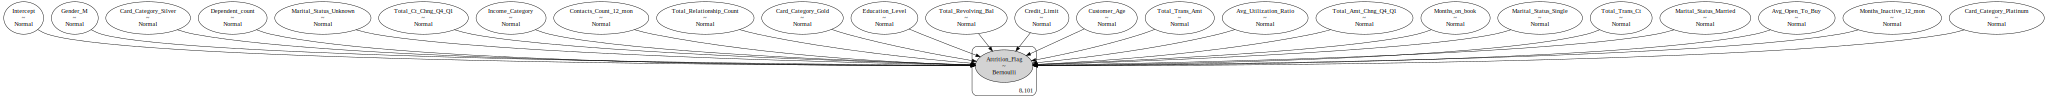

In [64]:
laplace_logit.graph()

In [58]:
az.summary(laplace_logit_result)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.745,0.203,-3.117,-2.354,0.011,0.008,367.0,612.0,1.02
Customer_Age,-0.040,0.068,-0.168,0.090,0.002,0.002,825.0,842.0,1.00
Dependent_count,0.194,0.044,0.119,0.282,0.002,0.002,383.0,971.0,1.02
Months_on_book,0.007,0.069,-0.123,0.133,0.002,0.002,776.0,1113.0,1.00
Total_Relationship_Count,-0.714,0.048,-0.809,-0.630,0.002,0.001,961.0,1028.0,1.00
Months_Inactive_12_mon,0.536,0.042,0.454,0.613,0.001,0.001,1379.0,920.0,1.01
Contacts_Count_12_mon,0.583,0.047,0.484,0.666,0.003,0.002,358.0,162.0,1.01
Credit_Limit,-0.066,1.663,-3.069,3.257,0.073,0.051,527.0,622.0,1.01
Total_Revolving_Bal,-0.767,0.162,-1.081,-0.476,0.007,0.005,540.0,667.0,1.01
Avg_Open_To_Buy,-0.018,1.663,-3.361,2.957,0.073,0.051,525.0,598.0,1.01


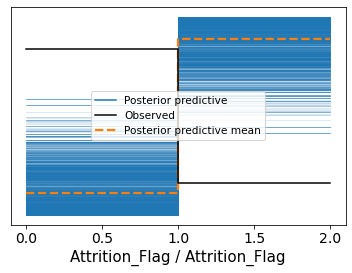

In [59]:
posterior_predictive_ = laplace_logit.predict(laplace_logit_result, kind="pps", data=x_test)
az.plot_ppc(trace);

In [60]:
# Compute the point prediction by taking the mean
# and defining the category via a threshold.
y_pred = (
    trace["posterior_predictive"]["Attrition_Flag"].values.mean(axis=0).mean(axis=0)
)
y_test_pred = (y_pred >= 0.5).astype("int")

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

accuracy =  0.191


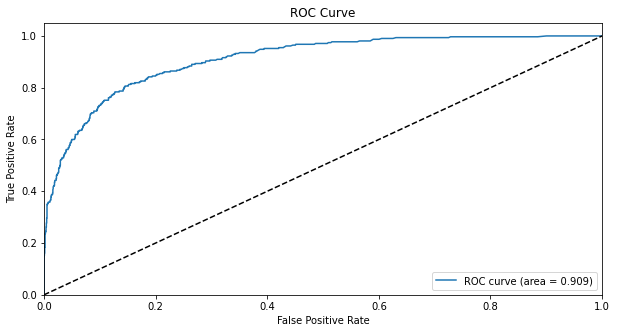

In [325]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:0.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc_curve(y_test, y_pred)

/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


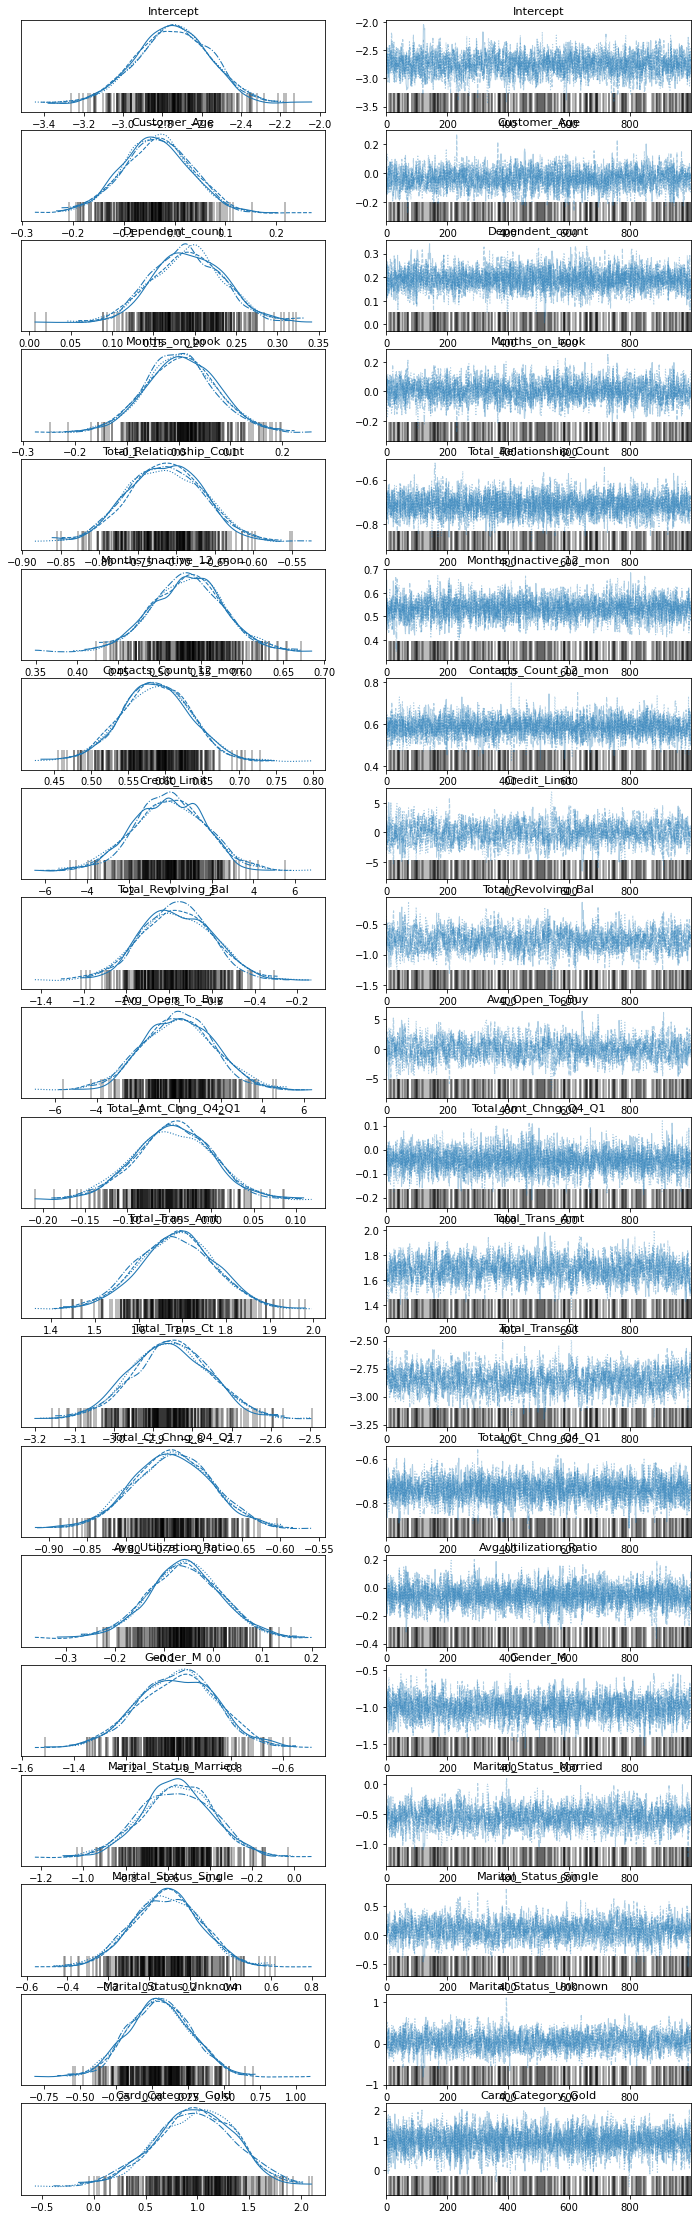

In [317]:
az.plot_trace(data=trace);

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Customer_Age'}>,
        <AxesSubplot:title={'center':'Dependent_count'}>,
        <AxesSubplot:title={'center':'Months_on_book'}>],
       [<AxesSubplot:title={'center':'Total_Relationship_Count'}>,
        <AxesSubplot:title={'center':'Months_Inactive_12_mon'}>,
        <AxesSubplot:title={'center':'Contacts_Count_12_mon'}>,
        <AxesSubplot:title={'center':'Credit_Limit'}>],
       [<AxesSubplot:title={'center':'Total_Revolving_Bal'}>,
        <AxesSubplot:title={'center':'Avg_Open_To_Buy'}>,
        <AxesSubplot:title={'center':'Total_Amt_Chng_Q4_Q1'}>,
        <AxesSubplot:title={'center':'Total_Trans_Amt'}>],
       [<AxesSubplot:title={'center':'Total_Trans_Ct'}>,
        <AxesSubplot:title={'center':'Total_Ct_Chng_Q4_Q1'}>,
        <AxesSubplot:title={'center':'Avg_Utilization_Ratio'}>,
        <AxesSubplot:title={'center':'Gender_M'}>],
       [<AxesSubplot:title={'center':'Marital_St

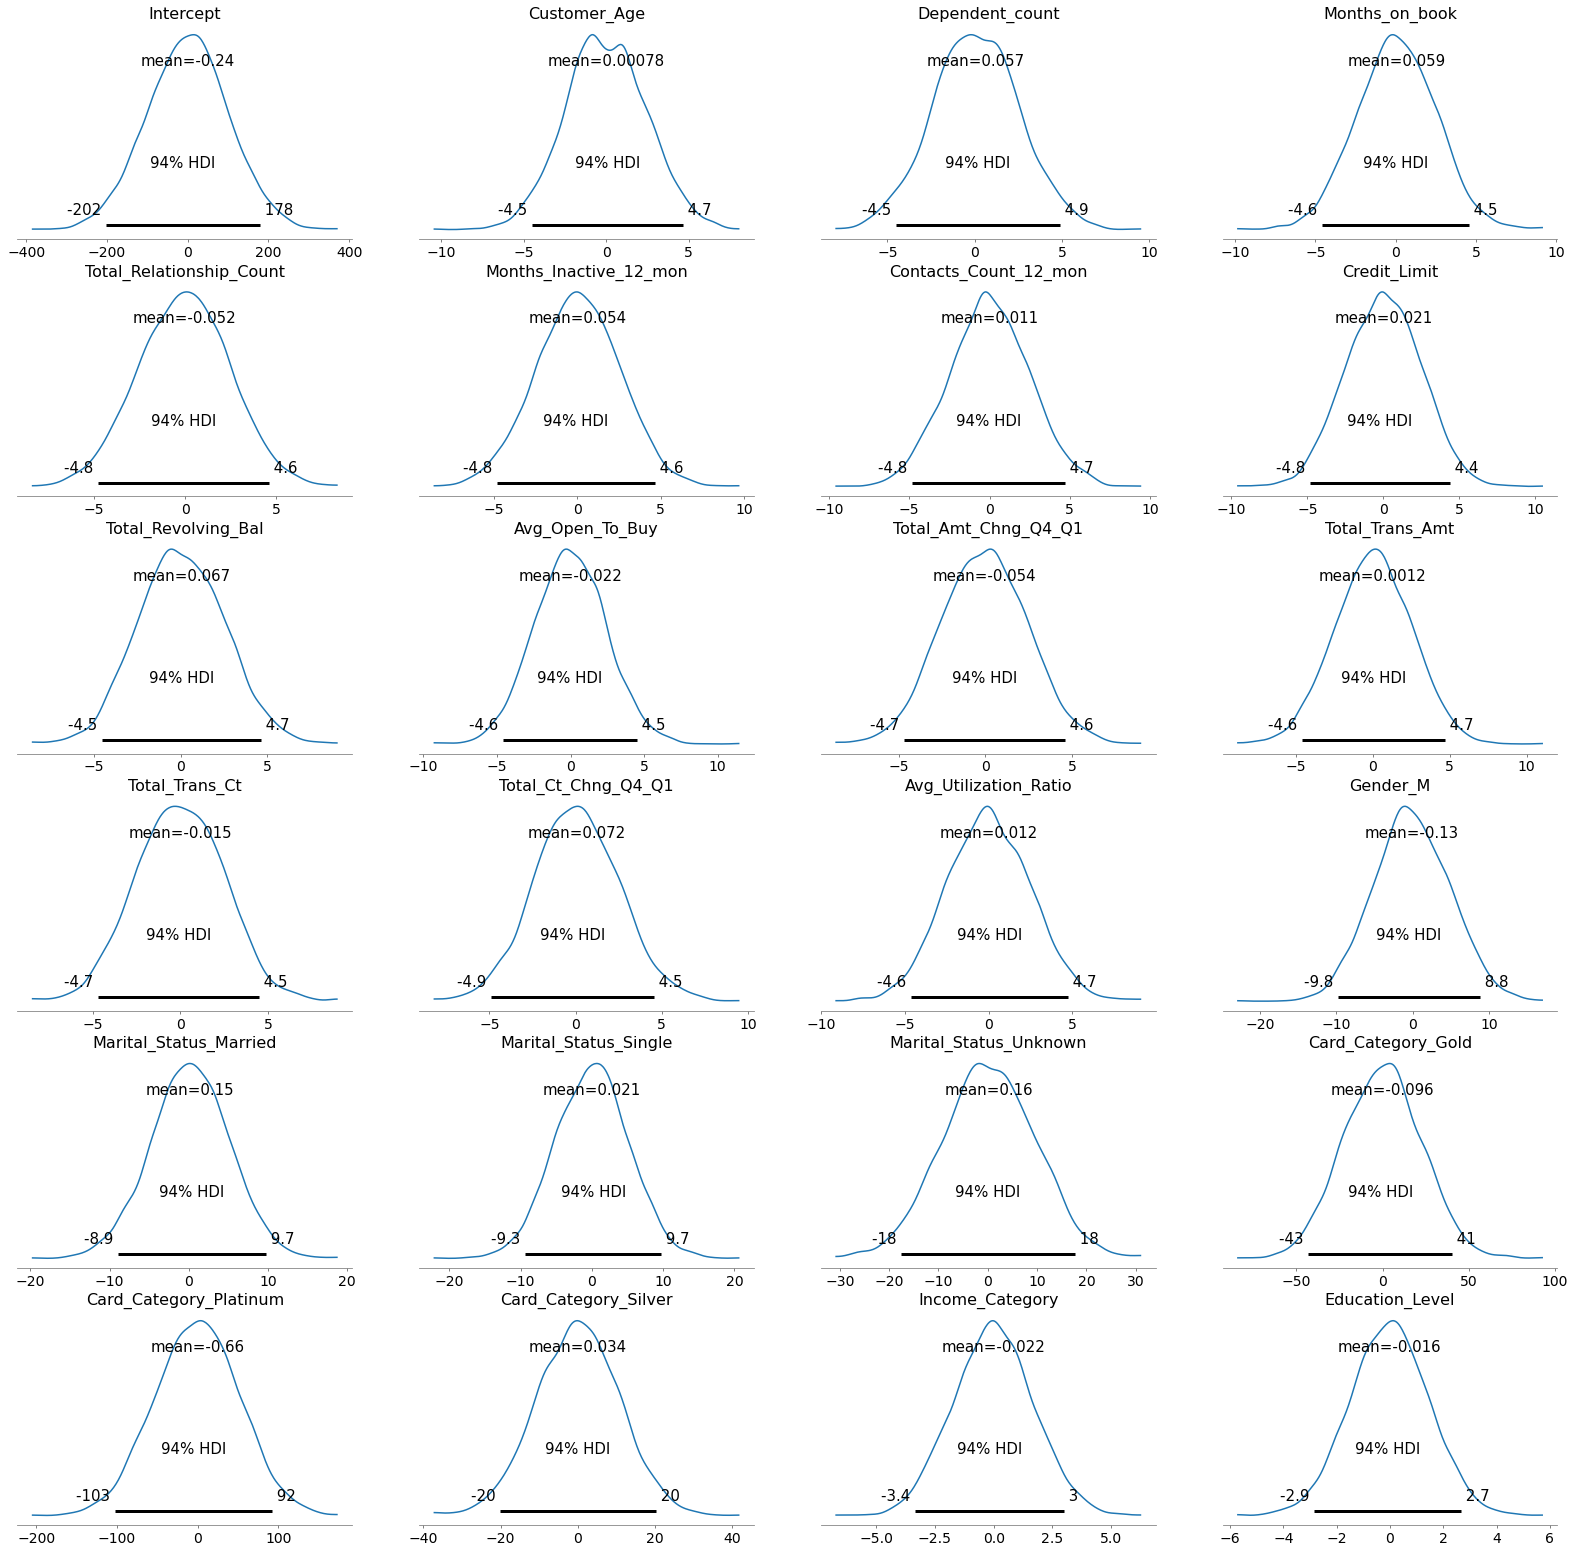

In [318]:
model.plot_priors()

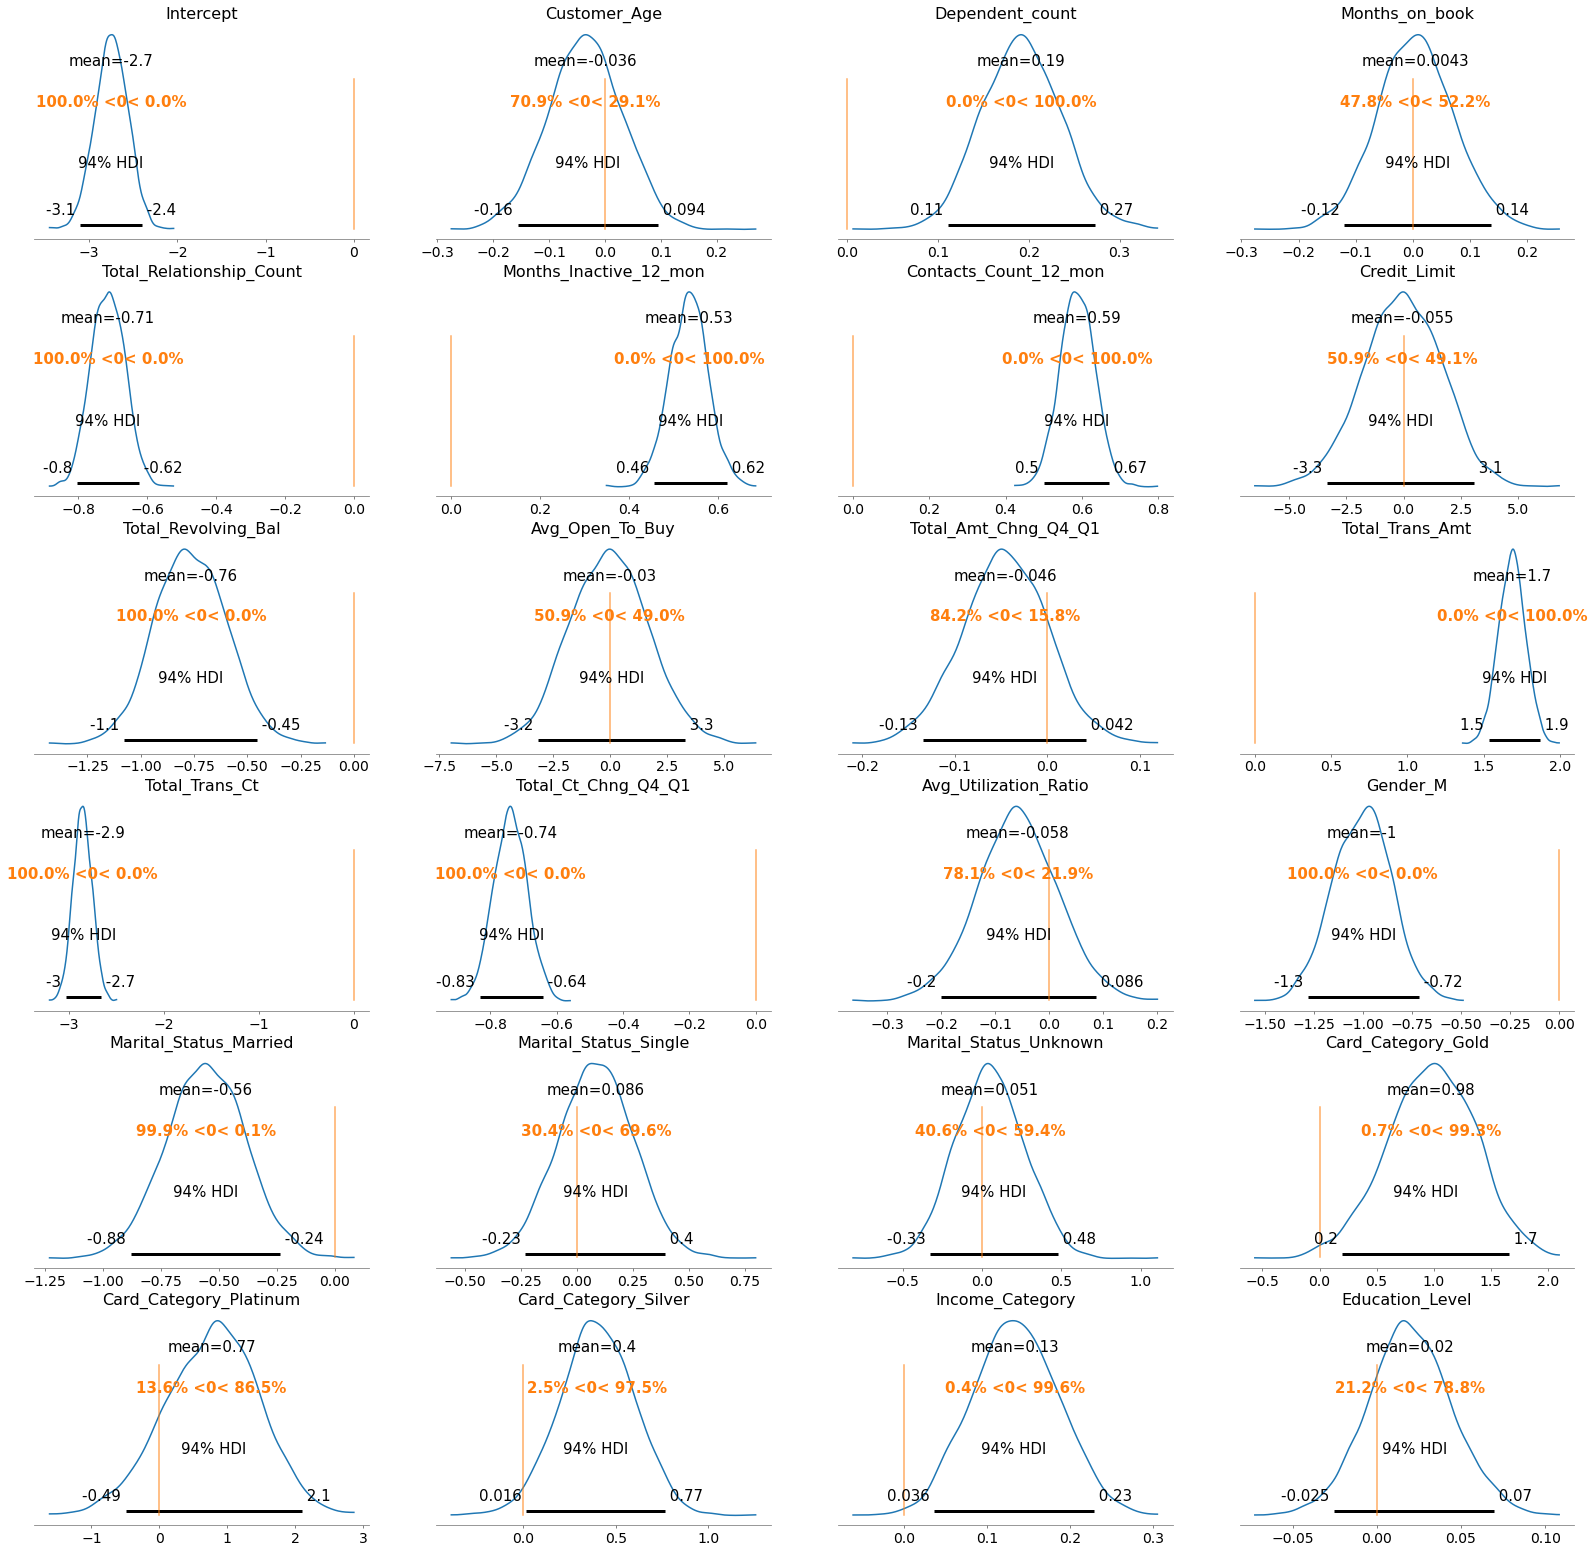

In [319]:
az.plot_posterior(trace, ref_val=0);

## LDA

In [323]:
clf = LinearDiscriminantAnalysis(solver='lsqr',store_covariance=True)
clf.fit(x_train, y_train)

LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True)

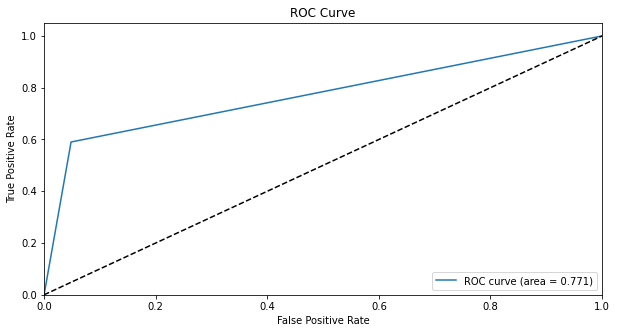

In [326]:
pred_lda = clf.predict(x_test)

plot_roc_curve(y_test, pred_lda)